In [1]:
from random import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

import sys
sys.path.append("..")
from influence.dataset import DataSet

## Data preparation

In [2]:
fpath_titanic = "/home/eolus/Desktop/Dauphine/datamining/projets/blackBox/data/train.csv"
data_df = pd.read_csv(fpath_titanic)
data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def extract_prefix(name):
    import re
    try:
        return re.search('(Mr\.)|(Mrs\.)|(Miss\.)', name).group()
    except:
        return ""

# Add prefix feature
data_df['Prefix'] = data_df.Name.apply(extract_prefix)

# Convert to categorical type
for cat_col in ['Sex', 'Embarked', 'Prefix' ]:
    data_df[cat_col] = pd.factorize(data_df[cat_col])[0]

# Fill NA
data_df['Age'].fillna(data_df.Age.mean(), inplace=True)

# Shuffle
data_df = data_df.sample(frac=1)

# Get train dataset and keep track of passengerIDs
train_df = data_df.iloc[:int(0.7*len(data_df))]
test_df = data_df.iloc[int(0.7*len(data_df)):]

train_idx = data_df.iloc[:int(0.7*len(data_df))]
                        
# Prepare X, y
columns = ['Prefix', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_train = np.array(train_df[columns])
X_test = np.array(test_df[columns])
y_train = np.array((train_df.Survived > 0).astype('int32'))
y_test = np.array((test_df.Survived > 0).astype('int32'))

# Retrieve PassengerId
train_idx = train_df.PassengerId.values.tolist()
test_idx = test_df.PassengerId.values.tolist()

# Scale X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model

In [4]:
def get_tf_model(X_train, X_test, y_train, y_test):
    """
    Fit BinaryLogisticRegressionWithLBFGS object using training data X_train, y_train
    X_test and y_test readily available in object attributes for eval
    """
    
    from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
    
    # Create dataset
    lr_train = DataSet(X_train, np.array(y_train, dtype=int))
    lr_test = DataSet(X_test, np.array(y_test, dtype=int))
    lr_validation = None
    lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)

    # Params
    num_classes = 2
    input_dim = len(X_test.T)
    weight_decay = 0.01
    batch_size = 100
    initial_learning_rate = 0.001 
    keep_probs = None
    decay_epochs = [1000, 10000]
    max_lbfgs_iter = 1000

    # Ini new graph
    with tf.Graph().as_default(): # Replaces tf.reset_default_graph() in jupyter env

        tf_model = BinaryLogisticRegressionWithLBFGS(
            input_dim=input_dim,
            weight_decay=weight_decay,
            max_lbfgs_iter=max_lbfgs_iter,
            num_classes=num_classes, 
            batch_size=batch_size,
            data_sets=lr_data_sets,
            initial_learning_rate=initial_learning_rate,
            keep_probs=keep_probs,
            decay_epochs=decay_epochs,
            mini_batch=False,
            train_dir='tmp',
            log_dir='tmp',
            model_name='titanic')
    
        # Fit model and return
        tf_model.train()
        return tf_model


def get_top_train_influence():
    """
    Approximate most influential train points for a test point
    idx : index of test point
    """
    tf_model = get_tf_model(X_train, X_test, y_train, y_test)
    
    num_train = len(tf_model.data_sets.train.labels)
    influences = tf_model.get_influence_on_test_loss(
        np.arange(len(tf_model.data_sets.test.labels)), 
        np.arange(len(tf_model.data_sets.train.labels)),
        force_refresh=True) * num_train
    influences_sorted = sorted(enumerate(influences),
                               key=lambda x:x[1],
                               reverse=True)
    return influences_sorted


def get_pred_score(tf_model):
    preds_p = tf_model.get_preds().tolist()
    preds = [1 if el[0] < 0.5 else 0 for el in preds_p]
    ref = tf_model.data_sets.test.labels

    same = 0
    for test_point in zip(preds, ref):
        if test_point[0] == test_point[1]:
            same += 1
    score = same / len(ref)
    return score

In [5]:
def get_model(X_train, y_train):
    from sklearn.linear_model import LogisticRegressionCV
    logit = LogisticRegressionCV()
    logit.fit(X_train, y_train)
    return logit

def get_score(X_test, y_test, X_train=None, y_train=None, model=None):
    if model is None:
        model = get_model(X_train, y_train)
    return model.score(X_test, y_test)

def get_predictions(X_test, y_test, X_train=None, y_train=None, model=None):
    if model is None:
        model = get_model(X_train, y_train)
    return model.predictions(X_test, y_test)


def get_scores(train_idx):
    
    # Get prediction score when using increasing fraction of training point starting from most influential
    scores = []
    for i in range(5, 105, 5):
        max_idx = int(i*len(train_idx)/100)
        sample_idx = train_idx[:max_idx]
        
        model = get_model(X_train=X_train[sample_idx], y_train=y_train[sample_idx])
        
        score = np.mean([
                get_score(X_test=X_test,
                          y_test=y_test,
                          model=model) for _ in range(3)])

        scores.append((i, score))
    
    return scores

In [6]:
import matplotlib.pyplot as plt
def plot(x, y, label):
    plt.plot( x, y, '-', label=label)

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Total number of parameters: 8
Using normal model
LBFGS training took [11] iter.
After training with LBFGS: 
Optimization terminated successfully.
         Current function value: -0.011656
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 10
         Hessian evaluations: 19


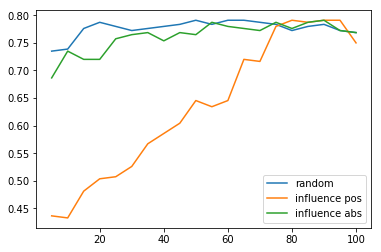

In [7]:
# Get prediction score when using increasing fraction of random training point
top_train_inf = get_top_train_influence()

train_infl_idx = [f[0] for f in top_train_inf]
train_rand_idx = sorted(train_infl_idx, key=lambda x: random())
train_abs_idx = [f[0] for f in sorted(top_train_inf, key=lambda x: abs(x[1]))]

# Get scores for random training order
scores_rand = get_scores(train_rand_idx)
scores_infl = get_scores(train_infl_idx)
scores_abs = get_scores(train_abs_idx)

# Plot
for scores, label in [
    (scores_rand, 'random'),
    (scores_infl, 'influence pos'),
    (scores_abs, 'influence abs') ]:
    x = [s[0] for s in scores]
    y = [s[1] for s in scores]
    plot(x, y, label)

plt.legend()
plt.show()

## Domain mismatch

In [13]:
model = get_model(X_train[train_infl_idx[:120]], y_train[train_infl_idx[:120]])

keep_issues = []
for i, decision_v_actual in enumerate(zip(model.decision_function(X_test), y_test)):
    decision_score, label = decision_v_actual
    #print(decision_score, prediction)
    if (decision_score > 0 and label == 0 or
        decision_score < 0 and label == 1):
        keep_issues.append( (i,decision_score ) )

most_wrong = sorted(keep_issues, key=lambda x : abs(x[1]), reverse=True)[:20]
most_wrong_test_idx = [el[0] for el in most_wrong]

In [46]:
most_wrong_passengerId = np.array(test_idx)[most_wrong_test_idx]
most_wrong_df = data_df[data_df.PassengerId.isin(most_wrong_passengerId)][columns]
most_wrong_df

,Prefix,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
22,2,3,1,15.000000,0,0,8.0292,2
412,2,1,1,33.000000,1,0,90.0000,2
274,2,3,1,29.699118,0,0,7.7500,2
186,1,3,1,29.699118,1,0,15.5000,2
299,1,1,1,50.000000,0,1,247.5208,1
602,0,1,0,29.699118,0,0,42.4000,0
198,2,3,1,29.699118,0,0,7.7500,2
156,2,3,1,16.000000,0,0,7.7333,2
748,0,1,0,19.000000,1,0,53.1000,0
31,1,1,1,29.699118,1,0,146.5208,1


In [45]:
set(most_wrong_df.Pclass.values.tolist())


{1, 2, 3}

In [47]:
sum(data_df.Sex.values) / len(data_df.Sex.values)

0.35241301907968575

In [54]:
opppp = [el[0] for el in sorted(keep_issues, key=lambda x : abs(x[1]))]
wrrrr = data_df[data_df.PassengerId.isin(np.array(test_idx)[opppp])][columns]

sum(wrrrr.Sex) / len(wrrrr)

0.37593984962406013

In [ ]:
get_top_train_influence